In [1]:
# Libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.layers import Dropout

In [2]:
#importing training dataset
train=pd.read_csv('../input/gtsrb-german-traffic-sign/Train.csv')
X_train=train['Path']
y_train=train.ClassId
train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [3]:
data_dir = "../input/gtsrb-german-traffic-sign"
train_imgpath= list((data_dir + '/' + str(train.Path[i])) for i in range(len(train.Path)))

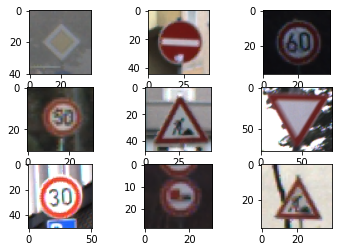

In [4]:
for i in range(0,9):
    plt.subplot(331+i)
    seed=np.random.randint(0,39210)
    im = Image.open(train_imgpath[seed])  
    plt.imshow(im)
    
plt.show()

# Preprocessing image-
converting images into arrays of the form (28,28,3)

In [5]:
train_data=[]
train_labels=[]


path = "../input/gtsrb-german-traffic-sign/"
for i in range(len(train.Path)):
    image=cv2.imread(train_imgpath[i])
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((28,28))
    train_data.append(np.array(size_image))
    train_labels.append(train.ClassId[i])


X=np.array(train_data)
y=np.array(train_labels)

In [6]:
#Spliting the images into train and validation sets

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.20, random_state=7777)  

In [7]:
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255

#Using one hote encoding for the train and validation labels
from keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

# CNN Model-

Grid Search to determine the layers and neurons in each layer in the sequential model.

In [8]:
def create_model(layers):
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 3]))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Flatten())
    
    for i, nodes in enumerate(layers):
        cnn.add(tf.keras.layers.Dense(units=nodes, activation='relu'))
            
    cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))
    
    cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn

model = KerasClassifier(build_fn=create_model, verbose=1)
layers = [[128],(256, 128),(200, 150, 120)]
param_grid = dict(layers=layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_val, y_val))
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


197/197 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.8203


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.4min finished


981/981 [==============================] - 4s 4ms/step - loss: 0.0393 - accuracy: 0.6603 - val_loss: 0.0124 - val_accuracy: 0.9069
Best: 0.8759197235107422, using {'layers': (256, 128)}
0.847706961631775 (0.03797045557476613) with: {'layers': [128]}
0.8759197235107422 (0.018868986840973226) with: {'layers': (256, 128)}
0.8197158336639404 (0.028552680330199684) with: {'layers': (200, 150, 120)}


Grid Search to determine the batch size

In [9]:
def create_model1():
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 3]))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
    cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
    cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))
    
    cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn

model = KerasClassifier(build_fn = create_model1, verbose = 1)

batch_size = [20,40]
param_grid = dict(batch_size=batch_size)

grid = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_val, y_val))

print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
params = grid_results.cv_results_['params']
for mean,param in zip(means,params):
    print('{0} with: {1}'.format(mean,param))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


157/157 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.8809


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   59.2s finished


1569/1569 [==============================] - 6s 4ms/step - loss: 0.0369 - accuracy: 0.6755 - val_loss: 0.0103 - val_accuracy: 0.9241
Best: 0.9017118453979492, using {'batch_size': 20}
0.9017118453979492 with: {'batch_size': 20}
0.858513343334198 with: {'batch_size': 40}


Grid Search to determine the dropout rate

In [10]:
def create_model2(dropout):
    # create model
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 3]))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
    cnn.add(Dropout(dropout))
    cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
    cnn.add(Dropout(dropout))
    cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))
    
    cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn

model = KerasClassifier(build_fn = create_model2, verbose = 1, batch_size=20)

dropout = [0.0, 0.1, 0.2]
param_grid = dict(dropout=dropout)

grid = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_val, y_val))

print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
params = grid_results.cv_results_['params']
for mean,param in zip(means,params):
    print('{0} with: {1}'.format(mean,param))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


314/314 [==============================] - 1s 2ms/step - loss: 0.0133 - accuracy: 0.8991


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.9min finished


1569/1569 [==============================] - 6s 4ms/step - loss: 0.0417 - accuracy: 0.6319 - val_loss: 0.0115 - val_accuracy: 0.9092
Best: 0.9027005791664123, using {'dropout': 0.1}
0.886727249622345 with: {'dropout': 0.0}
0.9027005791664123 with: {'dropout': 0.1}
0.893677806854248 with: {'dropout': 0.2}


Inputing the parameters in the final model (for better accuracy, you can run grid search multiple times zooming into each range used before)

In [12]:
#Definition of the DNN model

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))

# compile the model
cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn.fit(X_train, y_train, batch_size=20, epochs=20,validation_data=(X_val, y_val))

Epoch 1/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0416 - accuracy: 0.6294 - val_loss: 0.0100 - val_accuracy: 0.9239
Epoch 2/20
1569/1569 [==============================] - 7s 4ms/step - loss: 0.0073 - accuracy: 0.9456 - val_loss: 0.0047 - val_accuracy: 0.9661
Epoch 3/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0038 - accuracy: 0.9739 - val_loss: 0.0032 - val_accuracy: 0.9804
Epoch 4/20
1569/1569 [==============================] - 7s 4ms/step - loss: 0.0025 - accuracy: 0.9828 - val_loss: 0.0022 - val_accuracy: 0.9841
Epoch 5/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0021 - accuracy: 0.9859 - val_loss: 0.0024 - val_accuracy: 0.9841
Epoch 6/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0019 - accuracy: 0.9869 - val_loss: 0.0022 - val_accuracy: 0.9842
Epoch 7/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0013 - accuracy: 0.9910 - val_loss: 0.0022 - val_accuracy:

Plotting the values of accuracy and loss vs epoch to visually determine the suitable number of epochs required

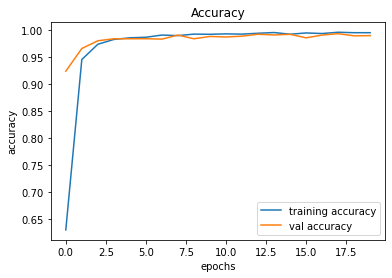

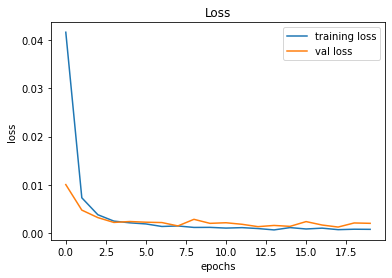

In [13]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# preparing test data

In [14]:
test=pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')
X_test=train['Path']
y_test=train.ClassId

In [15]:
data_dir = "../input/gtsrb-german-traffic-sign"
test_imgpath= list((data_dir + '/' + str(test.Path[i])) for i in range(len(test.Path)))

In [16]:
test_data=[]
test_labels=[]


path = "../input/gtsrb-german-traffic-sign/"
for i in range(len(test.Path)):
    image=cv2.imread(test_imgpath[i])
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((28,28))
    test_data.append(np.array(size_image))
    test_labels.append(test.ClassId[i])


X_test=np.array(test_data)
y_test=np.array(test_labels)

X_test = X_test.astype('float32')/255 

In [17]:
#predictions-
pred = cnn.predict_classes(X_test)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.9442596991290578